In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib.colors as clrs
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest, f_classif

fp_ds1= "./DS1_Normalized.csv"
fp_ds1_pre_proc = "./DS1_without_outliers.csv"
fp_ds2 = "./DS1_with_outliers.csv"
data = pd.read_csv(fp_ds1, parse_dates=False, sep=',')
data_pre_proc = pd.read_csv(fp_ds1_pre_proc, parse_dates=False, sep=',')
ds2 = pd.read_csv(fp_ds2, parse_dates=False, sep=';')
my_palette = {'yellow': '#ECD474', 'pale orange': '#E9AE4E', 'salmon': '#E2A36B', 'orange': '#F79522', 'dark orange': '#D7725E',
              'pale acqua': '#92C4AF', 'acqua': '#64B29E', 'marine': '#3D9EA9', 'green': '#10A48A', 'olive': '#99C244',
              'pale blue': '#BDDDE0', 'blue2': '#199ED5', 'blue3': '#1DAFE5', 'dark blue': '#0C70B2',
              'pale pink': '#D077AC', 'pink': '#EA4799', 'lavender': '#E09FD5', 'lilac': '#B081B9', 'purple': '#923E97',
              'white': '#FFFFFF', 'light grey': '#D2D3D4', 'grey': '#939598', 'black': '#000000'}

In [63]:
#CRIAR DADOS SÓ PARA O TRAIN_SET

In [64]:
import datetime as dt


NR_COLUMNS: int = 3
HEIGHT: int = 4


def choose_grid(nr):
    if nr < NR_COLUMNS:
        return 1, nr
    else:
        return (nr // NR_COLUMNS, NR_COLUMNS) if nr % NR_COLUMNS == 0 else (nr // NR_COLUMNS + 1, NR_COLUMNS)


def set_axes(xvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '', ylabel: str = '', percentage=False):
    if ax is None:
        ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(xvalues, fontsize='small', ha='center')

    return ax


def set_locators(xvalues: list, ax: plt.Axes = None):
    if isinstance(xvalues[0], dt.datetime):
        locator = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator, defaultfmt='%Y-%m-%d'))
    else:
        ax.set_xticks(xvalues)
        ax.set_xlim(xvalues[0], xvalues[-1])

    return ax


def plot_line(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '',
              ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)
    ax.plot(xvalues,  yvalues, c=cfg.LINE_COLOR)


def multiple_line_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                        xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)

    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend)


def bar_chart(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '',
              xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax.bar(xvalues, yvalues, edgecolor=my_palette['dark blue'], color=my_palette['pale blue'])


def multiple_bar_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                       xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)

    x = np.arange(len(xvalues))  # the label locations

    width = 0.8 / (len(xvalues)*len(yvalues))
    # the width of the bars
    step = width / len(xvalues)
    i: int = 0
    for metric in yvalues:
        ax.bar(x + i*width, yvalues[metric], width=width, align='center', label=metric)
        i += 1
    ax.set_xticks(x + width/len(xvalues) - step/2)
    ax.legend(fontsize='x-small', title_fontsize='small')


def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray,
                          ax: plt.Axes = None, normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=clrs.LinearSegmentedColormap.from_list("myCMPBlues", [my_palette['pale blue'], my_palette['blue2'], my_palette['blue3'], my_palette['dark blue']]))

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='w', horizontalalignment="center")


def plot_evaluation_results(labels: np.ndarray, trn_y, prd_trn, tst_y, prd_tst):
    cnf_mtx_trn = metrics.confusion_matrix(trn_y, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tst_y, prd_tst, labels)
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

    evaluation = {'Accuracy': [(tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn),
                               (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)],
                  'Recall': [tp_trn / (tp_trn + fn_trn), tp_tst / (tp_tst + fn_tst)],
                  'Specificity': [tn_trn / (tn_trn + fp_trn), tn_tst / (tn_tst + fp_tst)],
                  'Precision': [tp_trn / (tp_trn + fp_trn), tp_tst / (tp_tst + fp_tst)]}

    fig, axs = plt.subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])


def plot_roc_chart(models: dict, tstX: np.ndarray, tstY: np.ndarray, ax: plt.Axes = None, target: str = 'class'):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s' % target)

    ax.plot([0, 1], [0, 1], color='navy', label='random', linewidth=1, linestyle='--',  marker='')
    for clf in models.keys():
        metrics.plot_roc_curve(models[clf], tstX, tstY, ax=ax, marker='', linewidth=1)
    ax.legend(loc="lower right")

In [65]:
#del data['Unnamed: 0']
#data.head()

In [66]:
#WITH THE DATA PROCESSED

<Figure size 432x288 with 0 Axes>

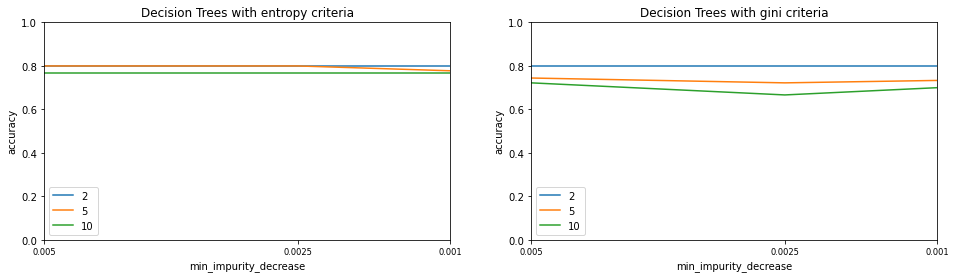

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.01 ==> accuracy=0.80


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
#import ds_functions as ds
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

min_impurity_decrease = [0.005, 0.0025, 0.001]
max_depths = [2, 5, 10]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
    multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

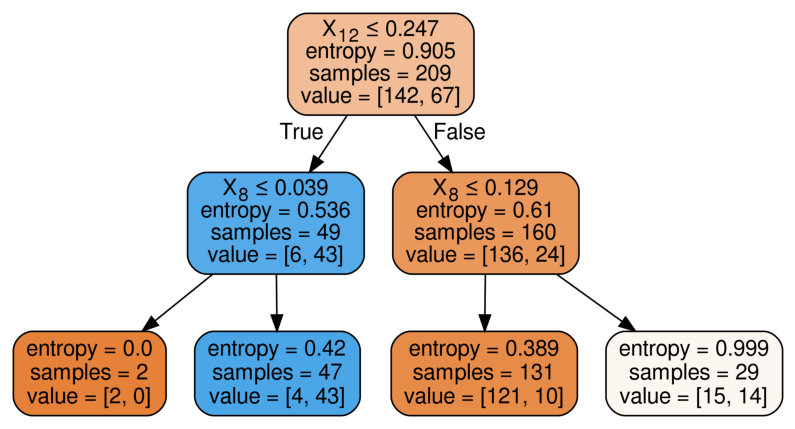

In [68]:
from sklearn.tree import export_graphviz

dot_data = export_graphviz(best_tree, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=600'])

plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('dtree.png'))
plt.axis('off')
plt.show()

/home/aid/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[1. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


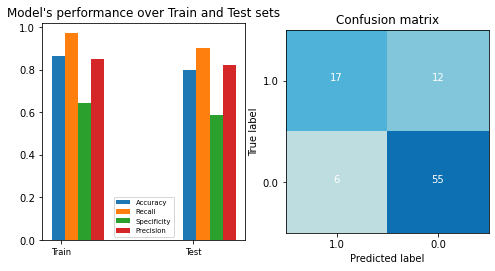

In [69]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

In [70]:
#WITH THE DATASET THAT HAS THE OUTLIERS

<Figure size 432x288 with 0 Axes>

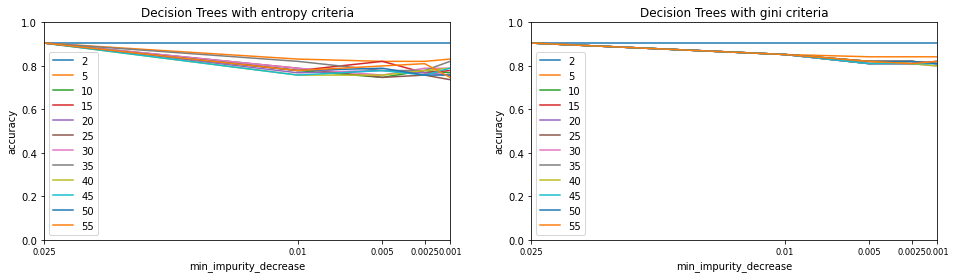

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.91


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
#import ds_functions as ds
y: np.ndarray = data_pre_proc.pop('DEATH_EVENT').values
X: np.ndarray = data_pre_proc.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree_2 = None

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree_2 = tree

        values[d] = yvalues
    multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

In [ ]:
#FAZER ANÁLISE PARA TREINO E PARA O TESTE (PRE-PRUNNING E POS-PRUNNING)
#

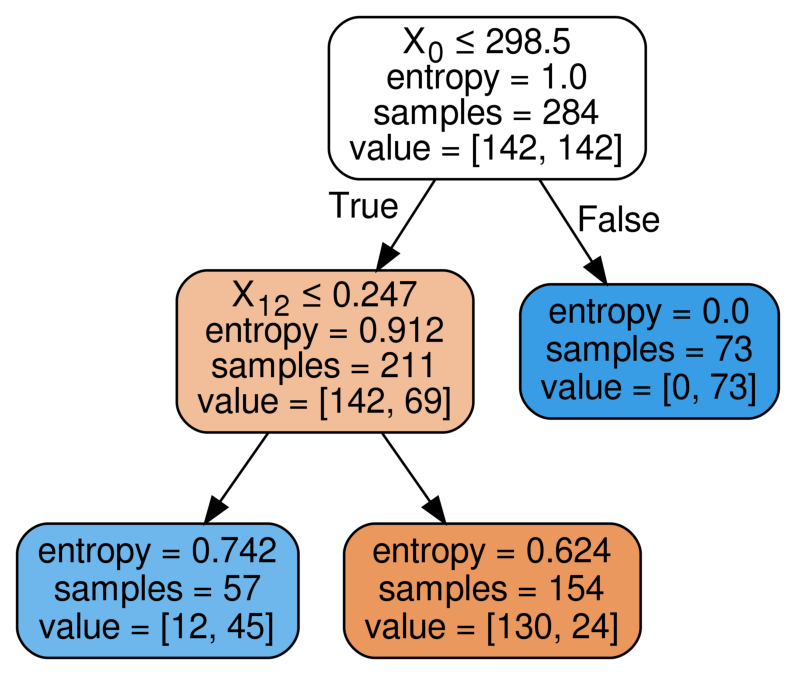

In [10]:
from sklearn.tree import export_graphviz

dot_data = export_graphviz(best_tree_2, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'dtree.dot', '-o', 'dtree.png', '-Gdpi=600'])

plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('dtree.png'))
plt.axis('off')
plt.show()

/home/aid/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[1. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


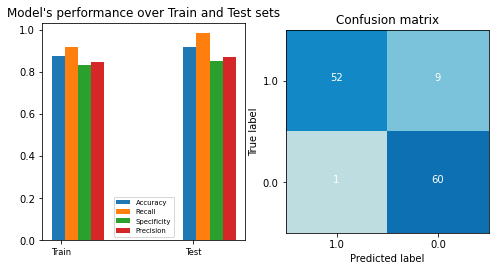

In [11]:
prd_trn_2 = best_tree_2.predict(trnX)
prd_tst_2 = best_tree_2.predict(tstX)
plot_evaluation_results(pd.unique(y), trnY, prd_trn_2, tstY, prd_tst_2)

<Figure size 432x288 with 0 Axes>

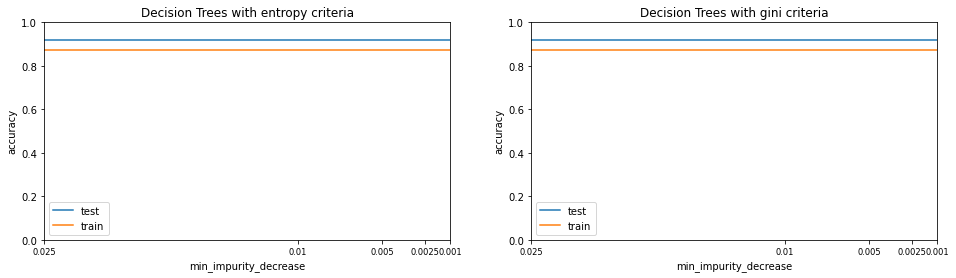

In [21]:
plt.figure()
fig,axs=plt.subplots(1,2, figsize=(16,4),squeeze=False)
for k in range(len(criteria)):
    f=criteria[k]
    values = {}
    
    values_y = []
    values_y_train = []
    for imp in min_impurity_decrease:
        tree = DecisionTreeClassifier(max_depth=best[1], criterion=f, min_impurity_decrease=imp)
        tree.fit(trnX, trnY)
        prdY = tree.predict(tstX)
        prdY_train = tree.predict(trnX)
        values_y.append(metrics.accuracy_score(tstY, prdY))
        values_y_train.append(metrics.accuracy_score(trnY,prdY_train))
    values['test'] = values_y
    values['train'] = values_y_train
    multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                       xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

plt.show()
    


In [ ]:


#FAZER CROSS VALIDATION